In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

In [2]:
preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
print(preDouble)

import pickle
fileObject = open('pure_control_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices = list(b)

import pickle
fileObject = open('pure_treatment_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices = list(b)

df = pd.read_pickle('dfpedsfFirsts.pickle')

\\iobsdc01\SharedDocs\SEER_MEDICARE\SEER_MEDICARE_STAGING


In [3]:
dg = pd.read_pickle('pure_goodindices_medpar.pickle')

d_t_c = dict(zip(treatmentindices, controlindices))
d_c_t = dict(zip(controlindices, treatmentindices))


dgtreatment = dg[dg.patient_id.isin(treatmentindices)].copy()

dgcontrol = dg[dg.patient_id.isin(controlindices)].copy()

df = df.set_index('patient_id',drop=False)

goodindices = controlindices + treatmentindices
print(len(goodindices),len(controlindices),len(treatmentindices))

df_all_good_indices = df.loc[goodindices].copy()

del df


monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}


df_all_good_indices['month1'] = df_all_good_indices['modx1'].replace(monthdict)

prostate_filter = df_all_good_indices['site1'].str.contains('prostate',case=False,na=False)
to_drop = list(df_all_good_indices[~prostate_filter].site1.index)
print(to_drop)

drop_set = set(to_drop)
t_set = set(d_t_c.keys())

lose_set = t_set.intersection(drop_set)
print(len(lose_set))

for i in list(lose_set):
    del d_t_c[i]
    
goodtreatmentindices = d_t_c.keys()
goodcontrolindices = d_t_c.values()
print(len(goodtreatmentindices), len(goodcontrolindices))

df_all_good_indices = df_all_good_indices.loc[list(goodcontrolindices) + list(goodtreatmentindices)]

df_all_good_indices['newmonth1'] = df_all_good_indices.month1.fillna('01').copy()

df_all_good_indices['yrdx_plus_modx'] = df_all_good_indices.yrdx1.astype('str') + df_all_good_indices.newmonth1.astype('str')


df_all_good_indices['yrdx_plus_modx'] = pd.to_datetime(df_all_good_indices['yrdx_plus_modx'], 
                                                      format='%Y%m')

dg = dg.set_index('patient_id',drop=False)

dgtreatment = dg[dg.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dgcontrol = dg[dg.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

1662 831 831
['4482160083', '2215176050', '8859072472', '2310153070', '8802026371', '8757024520', '8831097343', '8878004314', '8827010107', '4408106073', '8797097489', '8835013250', '4339013024', '4304141320', '4326238080', '4269060013', '8848090384', '4268053014', '8797035478', '8841081424', '8868081313', '4339033024', '4222034004', '8735038409', '8716025459', '4462162024', '8821066343', '8858012304', '8845030491', '8841000365', '8888027441', '4313295000', '8825058106', '8888086461', '4473112043', '8714009560', '8870085471', '8819038335', '8885077334', '8865081345', '8815026310', '8889005430', '4454195034', '4247072024', '8851092441', '8897051314', '4295048060', '8852000315', '8875067360', '4315229060']
25
806 806


In [4]:
dgtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgtreatment['site1'] = df_all_good_indices['site1']

dgcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgcontrol['site1'] = df_all_good_indices['site1']


dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date.astype('str').str.replace('\.0','')
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date_new.str.rjust(8,'0')

dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date.astype('str').str.replace('\.0','')
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date_new.str.rjust(8,'0')

dgtreatment['medpar_admission_date_new'] = pd.to_datetime(dgtreatment['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

dgcontrol['medpar_admission_date_new'] = pd.to_datetime(dgcontrol['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()




# <font color="#E56717">Calculating total payments (MedPAR file, Outpatient file, and NCH file) for each patient in the prostate PBT group and the matched prostate IMRT group</font>

* <span style="font-size:1.5em;">For each patient, sum all payments for dates after the prostate cancer dx date</span>

# <font color="#E56717">Hospital Data</font>

* <span style="font-size:1.5em;">MedPAR: Medicare Provider and Review</span>
* <span style="font-size:1.5em;">One record per stay</span>
* <span style="font-size:1.5em;">Key elements: admission and discharge diagnoses and dates, procedures and procedure dates, revenue center codes for ER, etc</span>
* <span style="font-size:1.5em;">Reports facility charges only</span>
* <span style="font-size:1.5em;">Paid by DRG (diagnostic review group) which is based on diagnoses and procedures</span>

# <font color="#E56717">Cost-related variables</font>

* <span style="font-size:1.5em;">Charges (what the hospital asked to be paid)</span>
* <span style="font-size:1.5em;">What the hospital was paid by Medicare: amount reimbursed plus bill total per diem</span>
* <span style="font-size:1.5em;">Deductibles</span>
* <span style="font-size:1.5em;">Primary Payer amount</span>

<span style="font-size:1.5em;">Medicare determines what the provider is allowed to charge for a serrvice ("allowed charges"). Payment of the allowed charges comes from two sources:

* <span style="font-size:1.5em;">Medicare</span>
* <span style="font-size:1.5em;">Beneficiary: Co-payments, coinsurance, and deductibles (may be paid by coinsurance such as Medigap)
* <span style="font-size:1.5em;">Hospitals have per-stay deductibles and co-payments</span>

# <font color="#E56717">Calculating MedPAR payments</font>

* <span style="font-size:1.5em;">Total payments from MEdicare are calculated as reimbursement amount plus total pass through amount</span>
* <span style="font-size:1.5em;">Primary payer amount is the amount paid by another insurance (before Medicare)</span>
* <span style="font-size:1.5em;">Total payments: need to add together Medicare payments, primary payer amount and copayment/deductible</span>


# <font color="#E56717">Use these fields in the MedPAR file</font>

* <span style="font-size:1.5em;">COINAMT - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for part A coinsurance for the stay</span>
* <span style="font-size:1.5em;">INPATDED - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for inpatient deductible for the stay</span>
* <span style="font-size:1.5em;">BLOODDED - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for the blood deductible for the stay</span>
* <span style="font-size:1.5em;">PRIPYAMT - The amount of payment (rounded to whole dollars) made on behalf of the beneficiary by a primary payer other than Medicare, which has been applied to the covered Medicare charges for the stay</span>
* <span style="font-size:1.5em;">INDMEDED - The amount of additional payment (rounded to whole dollars) made to teaching hospitals for IME for the stay</span>
* <span style="font-size:1.5em;">PASSTHRU - The total of all claim pass through amounts (rounded to whole dollars) for the stay</span>
* <span style="font-size:1.5em;">REIMBAMT - Amount of payment made from the Medicare trust fund for the services covered by the claim record</span>

In [5]:
dgcontrol['total_amt'] = dgcontrol['coinamt'] + dgcontrol['inpatded'] + \
dgcontrol['bloodded'] + dgcontrol['pripyamt'] +  \
dgcontrol['indmeded'] + dgcontrol['passthru'] + \
dgcontrol['reimbamt']

dgtreatment['total_amt'] = dgtreatment['coinamt'] + dgtreatment['inpatded'] + \
dgtreatment['bloodded'] + dgtreatment['pripyamt'] + \
dgtreatment['indmeded'] + dgtreatment['passthru'] + \
dgtreatment['reimbamt']


goodcols = ['medpar_admission_date_new','yrdx_plus_modx','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

dgtreatment['time_delta'] = dgtreatment['medpar_admission_date_new'] - dgtreatment['yrdx_plus_modx']

dgcontrol['time_delta'] = dgcontrol['medpar_admission_date_new'] - dgcontrol['yrdx_plus_modx']


def make_days(i):
    return i.days

dgtreatment['delta_days'] = dgtreatment['time_delta'].apply(make_days)
dgcontrol['delta_days'] = dgcontrol['time_delta'].apply(make_days)

goodcols = ['medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

good_claims_filter_treatment = dgtreatment.delta_days > 0
good_claims_filter_control = dgcontrol.delta_days > 0

dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

dgtreatment['srvm1'] = df_all_good_indices['srvm1']
dgcontrol['srvm1'] = df_all_good_indices['srvm1']


def make_months(i):
    return int(i.days/30)

dgtreatment['delta_months'] = dgtreatment['time_delta'].apply(make_months)
dgcontrol['delta_months'] = dgcontrol['time_delta'].apply(make_months)


goodcols = ['patient_id','medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days',
            'delta_months','srvm1','total_amt','los',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']


dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()



In [6]:

dgmedpartreatmentgroup = dgtreatmentgoodclaims.groupby('patient_id')
dgmedparcontrolgroup = dgcontrolgoodclaims.groupby('patient_id')

treatmentmedparagg = dgmedpartreatmentgroup[['total_amt','los']].agg(np.sum)
controlmedparagg = dgmedparcontrolgroup[['total_amt','los']].agg(np.sum)



In [7]:
treatmentmedparagg.describe()

,total_amt,los
count,327.000000,327.000000
mean,36400.639144,15.345566
std,47866.040142,27.008403
min,0.000000,1.000000
25%,9163.000000,2.000000
50%,20634.000000,5.000000
75%,44371.000000,15.500000
max,480172.000000,254.000000


In [8]:
controlmedparagg.describe() 

,total_amt,los
count,4.510000e+02,451.000000
mean,4.071565e+04,18.611973
std,9.765959e+04,40.945033
min,0.000000e+00,1.000000
25%,9.031500e+03,3.000000
50%,2.049000e+04,6.000000
75%,4.363300e+04,18.000000
max,1.853452e+06,468.000000


In [9]:
controlmedparagg.total_amt.sum(), treatmentmedparagg.total_amt.sum()

(18362756, 11903009)

# <font color="#E56717">Summary statistics of the Hospital payments</font>

|  | total_amt (IMRT) | los in days (IMRT) | total_amt (PBT) | los in days (PBT) |
|---|---------------|----------------|--------------------|----------------------|
|count | 451 | 451 | 327 | 327 |
| mean | 40715 | 19 | 36401 | 15 |
| 25% | 9031 | 3 | 9163 | 2 |
| 50% | 20490 | 6 | 20634 | 5 |
| 75% | 43633 | 18 | 44371 | 16 |

* <span style="font-size:1.5em;">$\sum$ total_amt for IMRT group =\$18,362,756</span>
* <span style="font-size:1.5em;">$\sum$ total_amt for PBT group = \$11,903,009</span>

# <font color="#E56717">Outpatient Claims from Facilities</font>

* <span style="font-size:1.5em;">Care that is provided by hospitals on an outpatient basis is found in the outpatient file</span>
* <span style="font-size:1.5em;">The billing form (UB-92) used for inpatient hospitalizations is also used for hospital outpatient, skilled nursing facility, home health and hospice claims</span>
* <span style="font-size:1.5em;">Exmple services include:</span>
    * <span style="font-size:1.5em;">Day surgery</span>
    * <span style="font-size:1.5em;">Therapeutic radiology</span>
    * <span style="font-size:1.5em;">ER not resulting in an inpatient admission</span>

# <font color="#E56717">Structure of Outpatient Data</font>
* <span style="font-size:1.5em;">The outpatient data are structured differently than the MedPAR even though they are both derived from facility claims. In the outpatient, there is a summary record with revenue center code 0001 for each bill</span>
* <span style="font-size:1.5em;">There is also one record for each revenue center code listed on the claim (and associated detail)</span>
    * <span style="font-size:1.5em;">These are not rolledup or combined in any way</span>
    * <span style="font-size:1.5em;">revenue center codes can repeat on a single claim</span>
* <span style="font-size:1.5em;">All records from a particular claim include the same non-revenue center level detail</span>
    * <span style="font-size:1.5em;">Therefore, a bill with one revenue center code would have two records in the file - a summary and the one for the single revenue center</span>
    * <span style="font-size:1.5em;">a bill with 10 revenue center codes would have 11 records in the file - the summary and the 10 specific codes. The basic information about the claim, claim from date and claim through date, total payments, etc., would be repeated 11 times</span>

# <font color="#E56717">Payments in the Outpatient file</font>

* <span style="font-size:1.5em;">Payments in the outpatient file are based on service, referred to as "Revenue Centers." This is similar to line items</span>
* <span style="font-size:1.5em;">Each line in the Outpatient file is a "Revenue Center" within a claim. Each claim contains at least two records, one of which is a summary record. The summary record contains Revenue Center = 0001</span>


In [10]:
dh = pd.read_pickle('pure_goodindices_outsaf.pickle')
dh = dh.set_index('patient_id', drop=False)

dhtreatment = dh[dh.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dhcontrol = dh[dh.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

dhtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dhtreatment['site1'] = df_all_good_indices['site1']

dhcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dhcontrol['site1'] = df_all_good_indices['site1']


dhtreatment['claim_from_date_new'] = dhtreatment.claim_from_date.astype('str').str.replace('\.0','')
dhtreatment['claim_from_date_new'] = dhtreatment.claim_from_date_new.str.rjust(8,'0')

dhtreatment['claim_through_date_new'] = dhtreatment.claim_through_date.astype('str').str.replace('\.0','')
dhtreatment['claim_through_date_new'] = dhtreatment.claim_through_date_new.str.rjust(8,'0')


dhcontrol['claim_from_date_new'] = dhcontrol.claim_from_date.astype('str').str.replace('\.0','')
dhcontrol['claim_from_date_new'] = dhcontrol.claim_from_date_new.str.rjust(8,'0')

dhcontrol['claim_through_date_new'] = dhcontrol.claim_through_date.astype('str').str.replace('\.0','')
dhcontrol['claim_through_date_new'] = dhcontrol.claim_through_date_new.str.rjust(8,'0')


dhtreatment['claim_from_date_new'] = pd.to_datetime(dhtreatment['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dhtreatment['claim_through_date_new'] = pd.to_datetime(dhtreatment['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

dhcontrol['claim_from_date_new'] = pd.to_datetime(dhcontrol['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dhcontrol['claim_through_date_new'] = pd.to_datetime(dhcontrol['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

dhtreatment['time_delta'] = dhtreatment['claim_from_date_new'] - dhtreatment['yrdx_plus_modx']

dhcontrol['time_delta'] = dhcontrol['claim_from_date_new'] - dhcontrol['yrdx_plus_modx']


dhtreatment['delta_days'] = dhtreatment['time_delta'].apply(make_days)
dhcontrol['delta_days'] = dhcontrol['time_delta'].apply(make_days)


goodcols = ['claim_from_date_new','yrdx_plus_modx','tot_seg','delta_days','patient_id','claim_from_date',
           'link_num','rec_count','center','pmt_amt','prpayamt',
           'ptntresp','rprvdpmt','pay','ptb_ded','ptb_coin',
           'blddedam','prvdrpmt']


good_claims_filter_treatment = dhtreatment.delta_days > 0
good_claims_filter_control = dhcontrol.delta_days > 0

dhtreatmentgoodclaims = dhtreatment[good_claims_filter_treatment].copy()
dhcontrolgoodclaims = dhcontrol[good_claims_filter_control].copy()



a = dhtreatmentgoodclaims.patient_id + dhtreatmentgoodclaims.claim_from_date_new.astype('str') + \
dhtreatmentgoodclaims.link_num.astype('str')

dhtreatmentgoodclaims['claim_id'] = a

a = dhcontrolgoodclaims.patient_id + dhcontrolgoodclaims.claim_from_date_new.astype('str') + \
dhcontrolgoodclaims.link_num.astype('str')

dhcontrolgoodclaims['claim_id'] = a


goodcols = ['claim_from_date_new','yrdx_plus_modx','claim_id','patient_id',
           'link_num','rec_count','center','pmt_amt','ptb_coin','ptb_ded','blddedam','rev_msp1']

# <font color="#E56717">Payments in the Outpatient file</font>

* <span style="font-size:1.5em;">Medicare Payment = pmt_amt</span>
* <span style="font-size:1.5em;">Beneficiary resopnsibility: ptb_ded + ptb_coni + blddedam</span>
* <span style="font-size:1.5em;">Primary payer claim paid amount: rev_msp1</span>

In [11]:
dhoutpatienttreatmentgroup = dhtreatmentgoodclaims.groupby(['patient_id','claim_id'])

dhoutpatientcontrolgroup = dhcontrolgoodclaims.groupby(['patient_id','claim_id'])


paymentcols = ['pmt_amt','blddedam','ptb_coin','ptb_ded','rev_msp1']

treatmentoutpatientagg = dhoutpatienttreatmentgroup[paymentcols].agg(np.max)

controloutpatientagg = dhoutpatientcontrolgroup[paymentcols].agg(np.max)


controloutpatientagg['total_amt_claim'] = controloutpatientagg[['pmt_amt','blddedam',
            'ptb_coin','ptb_ded','rev_msp1']].sum(axis=1)

treatmentoutpatientagg['total_amt_claim'] = treatmentoutpatientagg[['pmt_amt','blddedam',
            'ptb_coin','ptb_ded','rev_msp1']].sum(axis=1)



treatmentoutpatientagg.reset_index().head()
treatmentoutpatientagg.reset_index(inplace=True)
treatmentoutpatientagg = treatmentoutpatientagg.set_index('patient_id',drop=False)

controloutpatientagg.reset_index().head()
controloutpatientagg.reset_index(inplace=True)
controloutpatientagg = controloutpatientagg.set_index('patient_id',drop=False)


In [14]:
dhcontrolgroup = controloutpatientagg.groupby('patient_id')

dhtreatmentgroup = treatmentoutpatientagg.groupby('patient_id')

controloutpatient = controloutpatientagg[['patient_id',
        'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
controloutpatient.columns = controloutpatient.columns.droplevel()
controloutpatient.columns = ['total_amt','claim_count','mean_claim_amt']

treatmentoutpatient = treatmentoutpatientagg[['patient_id',
'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
treatmentoutpatient.columns = treatmentoutpatient.columns.droplevel()
treatmentoutpatient.columns = ['total_amt','claim_count','mean_claim_amt']

In [18]:
controloutpatient.describe()

,total_amt,claim_count,mean_claim_amt
count,777.000000,777.000000,777.000000
mean,24032.610618,27.158301,1163.549843
std,22159.825369,23.237388,992.124944
min,0.000000,1.000000,0.000000
25%,9345.720000,11.000000,467.633200
50%,24004.120000,21.000000,891.374483
75%,30587.880000,36.000000,1551.397246
max,243579.050000,213.000000,6723.015000


In [19]:
treatmentoutpatient.describe()

,total_amt,claim_count,mean_claim_amt
count,805.000000,805.000000,805.000000
mean,51445.550609,23.673292,3745.510992
std,24442.422398,21.973273,3278.811694
min,0.000000,2.000000,0.000000
25%,42358.610000,9.000000,1404.732800
50%,53668.870000,17.000000,2911.130526
75%,62546.480000,29.000000,5141.037273
max,335032.980000,144.000000,25483.880000


In [20]:
controloutpatient.total_amt.sum(), treatmentoutpatient.total_amt.sum()

(18673338.45, 41413668.23999992)

# <font color="#E56717">Summary statistics of the outpatient claims</font>

| | total_amt (IMRT) | claim_count (IMRT) | total_amt (PBT) | claim_count (PBT) |
|--|-----------------|----------------|-----------------|---------------------|
| count | 777 | 777 | 805 | 605 |
| mean | 24033 | 27 | 51445 | 24 |
| 25% | 9346 | 11 | 42359 | 9 |
| 50% | 24004 | 21 | 53668 | 17 | 
| 75% | 30587 | 36 | 62546 | 29 |

* <span style="font-size:1.5em;">$\sum$ total_amt for IMRT group: \$18,673,338</span>
* <span style="font-size:1.5em;">$\sum$ total_amt for PBT group: \$41,413,668</span>

# <font color="#E56717">Claims in the Carrier File (Physican/Supplier Part B or NCH)</font>

* <span style="font-size:1.5em;">Most of these claims are from physicians</span>
* <span style="font-size:1.5em;">They can also be from:</span>
    * <span style="font-size:1.5em;">other health personnel</span>
    * <span style="font-size:1.5em;">labs</span>
    * <span style="font-size:1.5em;">freestanding ambulatory care centers</span>
*  <span style="font-size:1.5em;">Includes physician services in a range of settings - office, hospital, nursing home, etc.</span>

# <font color="#E56717">To make the Carrier data easier to use</font>

*  <span style="font-size:1.5em;">The bills are turned into fixed-length records</span>
*  <span style="font-size:1.5em;">Each record includes the header (the summary information at the top of the form)</span>
*  <span style="font-size:1.5em;">one line item</span>
*  <span style="font-size:1.5em;">If during a doctor visit a patient has:</span>
    * <span style="font-size:1.5em;">office visit</span>
    * <span style="font-size:1.5em;">EKG</span>
    * <span style="font-size:1.5em;">Chest X-ray</span>
    * <span style="font-size:1.5em;">CBC</span>
* <span style="font-size:1.5em;">There would be four records, each with a common header and a unique line item</span>

In [21]:

di = pd.read_pickle('pure_goodindices_nch.pickle')
di = di.set_index('patient_id', drop=False)
ditreatment = di[di.patient_id.isin(goodtreatmentindices)].copy()

dicontrol = di[di.patient_id.isin(goodcontrolindices)].copy()

In [23]:
ditreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
ditreatment['site1'] = df_all_good_indices['site1']


dicontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dicontrol['site1'] = df_all_good_indices['site1']


ditreatment['claim_from_date_new'] = ditreatment.claim_from_date.astype('str').str.replace('\.0','')
ditreatment['claim_from_date_new'] = ditreatment.claim_from_date_new.str.rjust(8,'0')

ditreatment['claim_through_date_new'] = ditreatment.claim_through_date.astype('str').str.replace('\.0','')
ditreatment['claim_through_date_new'] = ditreatment.claim_through_date_new.str.rjust(8,'0')


dicontrol['claim_from_date_new'] = dicontrol.claim_from_date.astype('str').str.replace('\.0','')
dicontrol['claim_from_date_new'] = dicontrol.claim_from_date_new.str.rjust(8,'0')

dicontrol['claim_through_date_new'] = dicontrol.claim_through_date.astype('str').str.replace('\.0','')
dicontrol['claim_through_date_new'] = dicontrol.claim_through_date_new.str.rjust(8,'0')

ditreatment['claim_from_date_new'] = pd.to_datetime(ditreatment['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

ditreatment['claim_through_date_new'] = pd.to_datetime(ditreatment['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

dicontrol['claim_from_date_new'] = pd.to_datetime(dicontrol['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dicontrol['claim_through_date_new'] = pd.to_datetime(dicontrol['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()



goodcols = ['patient_id','claim_from_date_new','yrdx_plus_modx','hcpcs','link_num','srvc_cnt',
   'linediag','rec_count','pmt_amt','lintamt','ldedamt','coinamt','prpayamt',
           'prov_pmt']


ditreatment['time_delta'] = ditreatment['claim_from_date_new'] - ditreatment['yrdx_plus_modx']

dicontrol['time_delta'] = dicontrol['claim_from_date_new'] - dicontrol['yrdx_plus_modx']


ditreatment['delta_days'] = ditreatment['time_delta'].apply(make_days)
dicontrol['delta_days'] = dicontrol['time_delta'].apply(make_days)


goodcols = ['patient_id','claim_from_date_new','yrdx_plus_modx','delta_days','link_num','srvc_cnt',
   'linediag','rec_count','pmt_amt','lintamt','ldedamt','coinamt','prpayamt',
           'prov_pmt']


good_claims_filter_treatment = ditreatment.delta_days > 0
good_claims_filter_control = dicontrol.delta_days > 0

ditreatmentgoodclaims = ditreatment[good_claims_filter_treatment].copy()
dicontrolgoodclaims = dicontrol[good_claims_filter_control].copy()


a = ditreatmentgoodclaims.patient_id + ditreatmentgoodclaims.claim_from_date_new.astype('str') + \
ditreatmentgoodclaims.link_num.astype('str')

ditreatmentgoodclaims['claim_id'] = a


a = dicontrolgoodclaims.patient_id + dicontrolgoodclaims.claim_from_date_new.astype('str') + \
dicontrolgoodclaims.link_num.astype('str')

dicontrolgoodclaims['claim_id'] = a


goodcols = ['patient_id','claim_from_date_new','yrdx_plus_modx','delta_days','link_num','claim_id',
   'linediag','rec_count','pmt_amt','lintamt','ldedamt','coinamt','prpayamt',
           'prov_pmt']


dinchtreatmentgroup = ditreatmentgoodclaims.groupby(['patient_id','claim_id'])

dinchcontrolgroup = dicontrolgoodclaims.groupby(['patient_id','claim_id'])


paymentcols = ['pmt_amt','coinamt','prpayamt','ldedamt','lintamt'] # sum over coinamt, ldedamt and lintamt


treatmentnchagg = dinchtreatmentgroup[paymentcols].agg([np.max, np.sum ])
controlnchagg = dinchcontrolgroup[paymentcols].agg([np.max, np.sum])


treatmentnchagg.reset_index(inplace=True)
controlnchagg.reset_index(inplace=True)

treatmentnchagg = treatmentnchagg.set_index('patient_id', drop=False)
controlnchagg = controlnchagg.set_index('patient_id', drop=False)


# <font color="#E56717">Payments in the NCH file</font>

* <span style="font-size:1.5em;">Medicare payment + Beneficiary co-pay/deduct (sum of coinamt, ldedamt over line items) + ClaimPrimary Payer Amount</span>
* <span style="font-size:1.5em;">Claim Primary Payer Amount: prpayamt</span>
* <span style="font-size:1.5em;">Note: Claim Payment Amount, pmt-amt, repeats for each line item on the claim. Only count it once.</span>

In [24]:
treatmentnchagg.columns = treatmentnchagg.columns.droplevel()
treatmentnchagg.columns = ['patient_id','claim_id','pmt_amt_max','pmt_amt_sum',
                          'coinamt_max','coinamt_sum','prpayamt_max','prpayamt_sum',
                          'ldedamt_max','ldedamt_sum','lintamt_max','lintamt_sum']


controlnchagg.columns = controlnchagg.columns.droplevel()
controlnchagg.columns = ['patient_id','claim_id','pmt_amt_max','pmt_amt_sum',
                          'coinamt_max','coinamt_sum','prpayamt_max','prpayamt_sum',
                          'ldedamt_max','ldedamt_sum','lintamt_max','lintamt_sum']

del treatmentnchagg['pmt_amt_sum']
del treatmentnchagg['coinamt_max']
del treatmentnchagg['prpayamt_sum']
del treatmentnchagg['ldedamt_max']
del treatmentnchagg['lintamt_max']


del controlnchagg['pmt_amt_sum']
del controlnchagg['coinamt_max']
del controlnchagg['prpayamt_sum']
del controlnchagg['ldedamt_max']
del controlnchagg['lintamt_max']


controlnchagg['total_amt_claim'] = controlnchagg[['pmt_amt_max','coinamt_sum','prpayamt_max',
                            'ldedamt_sum','lintamt_sum']].sum(axis=1)


treatmentnchagg['total_amt_claim'] = treatmentnchagg[['pmt_amt_max','coinamt_sum','prpayamt_max',
                            'ldedamt_sum','lintamt_sum']].sum(axis=1)


dicontrolgroup = controlnchagg.groupby('patient_id')

ditreatmentgroup = treatmentnchagg.groupby('patient_id')


controlnch = controlnchagg[['patient_id',
        'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
controlnch.columns = controlnch.columns.droplevel()
controlnch.columns = ['total_amt','claim_count','mean_claim_amt']


treatmentnch = treatmentnchagg[['patient_id',
        'total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).copy()
treatmentnch.columns = treatmentnch.columns.droplevel()
treatmentnch.columns = ['total_amt','claim_count','mean_claim_amt']



In [25]:
controlnch.describe()

,total_amt,claim_count,mean_claim_amt
count,803.000000,803.000000,803.000000
mean,31076.357385,114.809465,286.649655
std,25573.306549,88.791343,206.592242
min,0.000000,1.000000,0.000000
25%,10054.910000,54.000000,142.874529
50%,23684.570000,94.000000,208.409245
75%,48383.195000,151.000000,375.755969
max,181753.710000,825.000000,1317.055870


In [26]:
treatmentnch.describe()

,total_amt,claim_count,mean_claim_amt
count,800.000000,800.00000,800.000000
mean,18323.880012,94.57500,185.573587
std,19898.713067,82.38371,116.155871
min,0.000000,1.00000,0.000000
25%,5901.955000,38.00000,129.722621
50%,11250.485000,72.50000,156.501273
75%,23542.582500,131.25000,194.630655
max,172218.990000,781.00000,1120.771282


In [27]:
controlnch.total_amt.sum(), treatmentnch.total_amt.sum()

(24954314.979999993, 14659104.009999977)

# <font color="#E56717">Summary statistics of the NCH claims</font>

| | total_amt (IMRT) | claim_count (IMRT) | total_amt (PBT) | claim_count (PBT) |
|--|------------------|------------|----------------|------------------|
|count | 803 | 803 | 800 | 800 |
| mean | 31076 | 115 | 18323 | 95 |
| 25% | 10055 | 54 | 5901 | 38 |
| 50% | 23685 | 94 | 11250 | 73 |
| 75% | 48383 | 151 | 23543 | 131 |

* <span style="font-size:1.5em;">$\sum$ total_amt for IMRT group: \$24,954,315</span>
* <span style="font-size:1.5em;">$\sum$ total_amt for PBT group: \$14,659,104</span>

In [28]:
controloutpatient.columns = ['total_amt_outpatient','claim_count_outpatient',
                            'mean_claim_amt_outpatient']

controlnch.columns = ['total_amt_nch','claim_count_nch','mean_claim_amt_nch']

controlmedparagg.columns = ['total_amt_medpar','los']

controloutpatient_nch_medpar = pd.concat([controloutpatient, controlnch, controlmedparagg], axis=1)

controloutpatient_nch_medpar['total'] = controloutpatient_nch_medpar[['total_amt_outpatient',
                                                     'total_amt_nch','total_amt_medpar']].sum(axis=1)

treatmentoutpatient.columns = ['total_amt_outpatient','claim_count_outpatient',
                            'mean_claim_amt_outpatient']


treatmentnch.columns = ['total_amt_nch','claim_count_nch','mean_claim_amt_nch']

treatmentmedparagg.columns = ['total_amt_medpar','los']

treatmentoutpatient_nch_medpar = pd.concat([treatmentoutpatient, treatmentnch, treatmentmedparagg], axis=1)

treatmentoutpatient_nch_medpar['total'] = treatmentoutpatient_nch_medpar[['total_amt_outpatient',
                                                     'total_amt_nch','total_amt_medpar']].sum(axis=1)

In [29]:
controloutpatient_nch_medpar.total.describe()

count    8.060000e+02
mean     7.691118e+04
std      8.515981e+04
min      0.000000e+00
25%      4.045784e+04
50%      5.760224e+04
75%      8.974081e+04
max      1.895731e+06
Name: total, dtype: float64

In [30]:
treatmentoutpatient_nch_medpar.total.describe()

count       806.000000
mean      84337.197581
std       53411.697041
min         594.360000
25%       57891.452500
50%       69068.890000
75%       91216.870000
max      595088.040000
Name: total, dtype: float64

In [31]:
controloutpatient_nch_medpar.total.sum(), treatmentoutpatient_nch_medpar.total.sum()

(61990409.43000007, 67975781.25)

# <font color="#E56717">Summary statistics for grand total from all three sources</font>

| | total (IMRT) | total (PBT) |
|--|--------|----------|
| count | 806 | 806 |
| mean | 76911 | 84337 |
| 25% | 40458 | 57891 |
| 75% | 89741 | 91217 |

* <span style="font-size:1.5em;">$\sum$ total for IMRT group: \$61,990,409</span>
* <span style="font-size:1.5em;">$\sum$ total for PBT group: \$67,975,781</span>

(0, 400000)

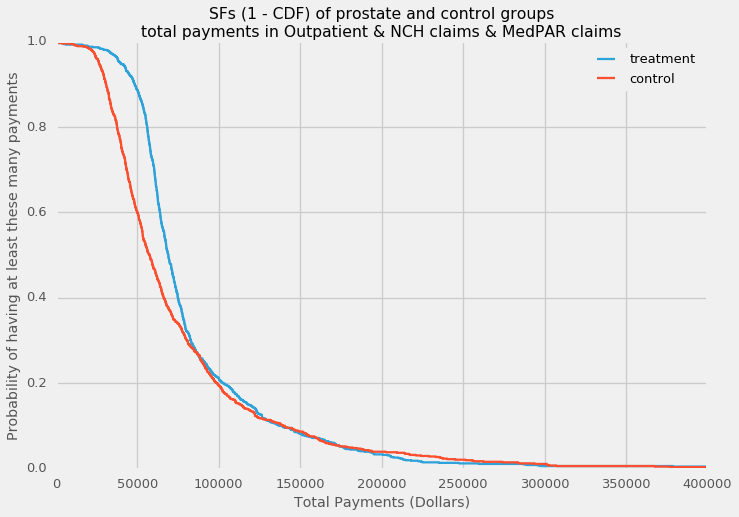

In [33]:
at = 1 -treatmentoutpatient_nch_medpar['total'].value_counts(normalize=True).sort_index().cumsum()
ac = 1 -controloutpatient_nch_medpar['total'].value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control',ax=ax)
plt.legend()
plt.xlabel("Total Payments (Dollars)")
plt.ylabel("Probability of having at least these many payments")
plt.title('SFs (1 - CDF) of prostate and control groups\ntotal payments in Outpatient & NCH claims & MedPAR claims')
plt.xlim(0,400000)

In [34]:
from collections import OrderedDict
treatmentoutpatient_nch_medpar_dict = OrderedDict()

for i in range(len(list(d_t_c.keys()))):
    treatmentoutpatient_nch_medpar_dict[list(d_t_c.keys())[i]] = treatmentoutpatient_nch_medpar['total'].loc[list(d_t_c.keys())[i]]

In [35]:
from collections import OrderedDict
controloutpatient_nch_medpar_dict = OrderedDict()
for i in range(len(list(d_t_c.values()))):
    controloutpatient_nch_medpar_dict[list(d_t_c.values())[i]] = controloutpatient_nch_medpar['total'].loc[list(d_t_c.values())[i]]

In [36]:
q = list(treatmentoutpatient_nch_medpar_dict.items())

treatmentvals = [q[p][1] for p in range(len(list(treatmentoutpatient_nch_medpar_dict.items())))]

treatmentindex = [q[p][0] for p in range(len(list(treatmentoutpatient_nch_medpar_dict.items())))]

q = list(controloutpatient_nch_medpar_dict.items())

controlvals = [q[p][1] for p in range(len(list(controloutpatient_nch_medpar_dict.items())))]

controlindex = [q[p][0] for p in range(len(list(controloutpatient_nch_medpar_dict.items())))]

dfoutpatient_nch_medpar = pd.DataFrame({'control_vals': controlvals,
                               'control_ids': controlindex,
                               'treatment_vals': treatmentvals,
                               'treatment_ids': treatmentindex})




(0, 250000)

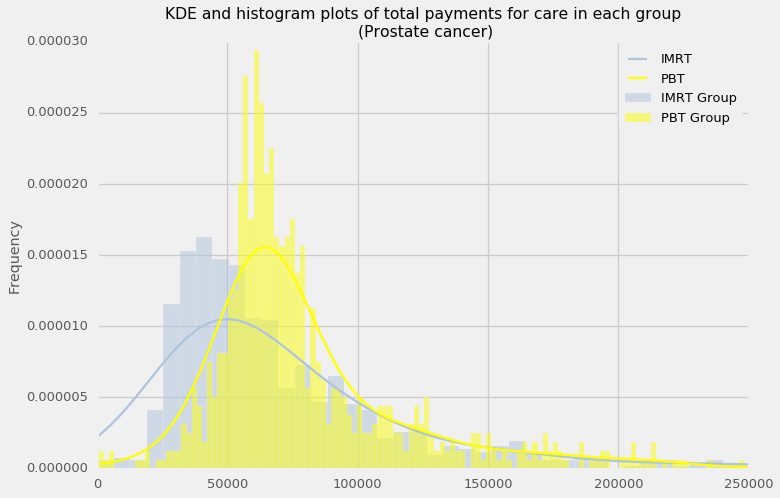

In [52]:
ax = dfoutpatient_nch_medpar.control_vals.plot(kind='kde',label='IMRT',color='LightSteelBlue')
dfoutpatient_nch_medpar.treatment_vals.plot(kind='kde',ax=ax,label='PBT',color='yellow')
dfoutpatient_nch_medpar.control_vals.plot(kind='hist',bins=300,color='LightSteelBlue',alpha=.5,
                                         normed=True,label='IMRT Group')
dfoutpatient_nch_medpar.treatment_vals.plot(kind='hist',bins=300,color='yellow',alpha=.5,
                                         normed=True,label='PBT Group')
plt.legend()
plt.title('KDE and histogram plots of total payments for care in each group\n (Prostate cancer)')
plt.xlim(0,250000)

# <font color="#E56717">Wilcoxon test for the significance of the observed difference in total payments betweent the IMRT and PBT groups</font>

In [53]:
from scipy.stats import ranksums, wilcoxon

t, p = wilcoxon(dfoutpatient_nch_medpar.control_vals.as_matrix(),
               dfoutpatient_nch_medpar.treatment_vals.as_matrix())

print(t,p)

121884.0 7.28719372104e-10


# <font color="#E56717">Non-paired test of the significance</font>



In [54]:
from scipy.stats import ttest_ind

t, p = ttest_ind(dfoutpatient_nch_medpar.control_vals.as_matrix(),
               dfoutpatient_nch_medpar.treatment_vals.as_matrix())

print(t,p)

-2.09727505335 0.0361248480388


# <font color="#E56717">Plot of the difference between pairs (PBT - IMRT)</font>

(-200000, 200000)

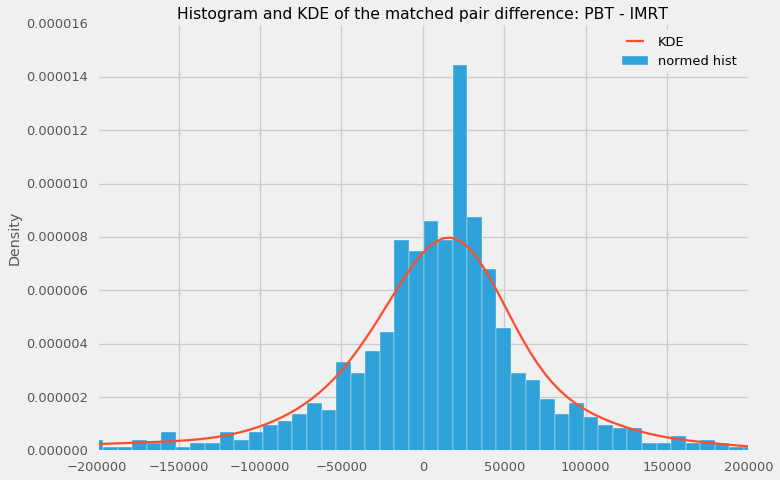

In [62]:
dfoutpatient_nch_medpar['diff'] = dfoutpatient_nch_medpar.treatment_vals - dfoutpatient_nch_medpar.control_vals
ax = dfoutpatient_nch_medpar['diff'].plot(kind='hist',bins=250,normed=True,label='normed hist')
dfoutpatient_nch_medpar['diff'].plot(kind='kde',ax=ax, label='KDE')
plt.legend()
plt.title('Histogram and KDE of the matched pair difference: PBT - IMRT')
plt.xlim(-200000,200000)

In [63]:
from scipy.stats import ttest_rel

t, p = ttest_rel(dfoutpatient_nch_medpar.control_vals.as_matrix(),
               dfoutpatient_nch_medpar.treatment_vals.as_matrix())

print(t,p)

-2.21538661826 0.0270126809788


In [64]:
from scipy.stats import bayes_mvs

In [65]:
bayes_mvs(dfoutpatient_nch_medpar['control_vals'].as_matrix())

(Mean(statistic=76911.177952853584, minmax=(71971.547005475062, 81850.808900232107)),
 Variance(statistic=7270256333.0923176, minmax=(6694076030.6137133, 7887537134.0864153)),
 Std_dev(statistic=85239.256268168465, minmax=(81817.333313997151, 88811.807402430655)))

In [66]:
bayes_mvs(dfoutpatient_nch_medpar['treatment_vals'].as_matrix())

(Mean(statistic=84337.197580645166, minmax=(81239.092202344022, 87435.302958946311)),
 Variance(statistic=2859914759.0741549, minmax=(2633261601.9569988, 3102735698.5808721)),
 Std_dev(statistic=53461.523968091322, minmax=(51315.315471669841, 55702.205509125772)))

In [67]:
def CohenEffectSize(group1, group2):
    import math
    diff = group1.mean() - group2.mean()
    
    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)
    
    pooled_var = (n1*var1 + n2*var2) / (n1 + n2)
    d = diff / math.sqrt(pooled_var)
    return d

In [68]:
ef = CohenEffectSize(dfoutpatient_nch_medpar.treatment_vals,
                     dfoutpatient_nch_medpar.control_vals)
print(ef)

0.10447271183005459


In [71]:
from scipy import stats

In [72]:
def get_means(seriesone, seriestwo,iters):
    """getting p-values for difference of means 
    test statistic."""
    realmean = seriesone.mean() - seriestwo.mean()
    print(realmean)
    pool = pd.concat([seriesone,seriestwo])
    dftoshuffle = pd.DataFrame(pool)
    deltameans = list()
    for i in range(iters):
        dffirsts = dftoshuffle.sample(seriesone.shape[0])
        dfseconds = dftoshuffle.loc[list(set(dftoshuffle.index) - set(dffirsts.index))]
        deltameans.append(abs(dffirsts.mean()[0] - dfseconds.mean()[0]))
    meansseries = pd.Series(deltameans)
    print((100.-stats.percentileofscore(meansseries, realmean))/100.)
    return meansseries

In [73]:
meanseries = get_means(dfoutpatient_nch_medpar.treatment_vals,
                      dfoutpatient_nch_medpar.control_vals,100000)

7426.019627791582
0.09981


In [ ]:
def get_means_2(seriesone, seriestwo,iters):
    """getting p-values for difference of means 
    test statistic."""
    realmean = seriesone.mean() - seriestwo.mean()
    print(realmean)
    pool = pd.concat([seriesone,seriestwo])
    dftoshuffle = pd.DataFrame(pool)
    deltameans = list()
    for i in range(iters):
        dffirsts = dftoshuffle.sample(seriesone.shape[0])
        dfseconds = dftoshuffle.loc[list(set(dftoshuffle.index) - set(dffirsts.index))]
        deltameans.append(dffirsts.mean()[0] - dfseconds.mean()[0])
    meansseries = pd.Series(deltameans)
    print((100.-stats.percentileofscore(meansseries, realmean))/100.)
    return meansseries

In [ ]:
meanseries = get_means_2(dfoutpatient_nch_medpar.treatment_vals,
                      dfoutpatient_nch_medpar.control_vals,200000)

7426.019627791582
